### **PneumoLiteCovNet-25 (Custom Model)**


#### **LOADING LIBRARIES**

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import tensorflow_hub as hub
import time

# Data augmentation and model preparation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2, NASNetMobile
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.nasnet import preprocess_input as nasnet_preprocess
from tensorflow.keras.layers import (AveragePooling2D, Dropout, Flatten, Dense, Input,
                                    GlobalAveragePooling2D, Conv2D, DepthwiseConv2D,
                                    BatchNormalization, Activation, Add, Reshape, multiply,
                                    Concatenate, MaxPooling2D)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

#### **Define Paths & Load Data**

In [ ]:
# Define paths
BASE_PATH = "/content/drive/MyDrive/chest_xray"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
TEST_PATH = os.path.join(BASE_PATH, "test")

labels = ['NORMAL', 'PNEUMONIA']
img_size = 224

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                data.append([img_path, label])
            except Exception as e:
                print(e)
    return pd.DataFrame(data, columns=['filepath', 'label'])

# Load data
train = get_data(TRAIN_PATH)
test = get_data(TEST_PATH)

print(train.head(5))
print(f"\nThe shape of The Train data is: {train.shape}")
print(f"The shape of The Test data is: {test.shape}")

                                            filepath      label
0  /content/drive/MyDrive/chest_xray/train/PNEUMO...  PNEUMONIA
1  /content/drive/MyDrive/chest_xray/train/PNEUMO...  PNEUMONIA
2  /content/drive/MyDrive/chest_xray/train/PNEUMO...  PNEUMONIA
3  /content/drive/MyDrive/chest_xray/train/PNEUMO...  PNEUMONIA
4  /content/drive/MyDrive/chest_xray/train/PNEUMO...  PNEUMONIA

The shape of The Train data is: (5233, 2)
The shape of The Test data is: (625, 2)


#### **DATA PREPROCESSING**

In [ ]:
# Create datasets
IMAGE_SIZE = (224, 224)

print('\nTraining Images:')
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.1,
    subset='training',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('\nValidation Images:')
validation_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.1,
    subset='validation',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('\nTesting Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

# Get class names
train_labels = train_ds.class_names
test_labels = test_ds.class_names
validation_labels = validation_ds.class_names

class_labels = ['NORMAL', 'PNEUMONIA']
label_encoder = LabelEncoder()
label_encoder.fit(class_labels)

# Normalize pixel values
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))


Training Images:
Found 5232 files belonging to 2 classes.
Using 4709 files for training.

Validation Images:
Found 5232 files belonging to 2 classes.
Using 523 files for validation.

Testing Images:
Found 624 files belonging to 2 classes.


In [ ]:
# Count files
def retrieveNumberOfFiles(path):
    return len([f for f in os.listdir(os.path.join(path, "NORMAL")) if f.endswith('.jpeg')] +
               [f for f in os.listdir(os.path.join(path, "PNEUMONIA")) if f.endswith('.jpeg')])

totalTrain = retrieveNumberOfFiles(TRAIN_PATH)
totalTest = retrieveNumberOfFiles(TEST_PATH)

# Get class weights
allTrainFiles = [os.path.join(TRAIN_PATH, "NORMAL", f) for f in os.listdir(os.path.join(TRAIN_PATH, "NORMAL"))] + \
                [os.path.join(TRAIN_PATH, "PNEUMONIA", f) for f in os.listdir(os.path.join(TRAIN_PATH, "PNEUMONIA"))]

trainLabels = [0 if "NORMAL" in p else 1 for p in allTrainFiles]
trainLabels = to_categorical(trainLabels)
classTotals = trainLabels.sum(axis=0)
classWeight = {i: classTotals.max() / classTotals[i] for i in range(len(classTotals))}

# Data generators
BATCH_SIZE = 32
INIT_LR = 1e-4
EPOCHS = 25

trainAug = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest")

valAug = ImageDataGenerator(preprocessing_function=mobilenet_preprocess)

trainGen = trainAug.flow_from_directory(
    TRAIN_PATH,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=True,
    batch_size=BATCH_SIZE)

validationGen = valAug.flow_from_directory(
    TRAIN_PATH,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)

testGen = valAug.flow_from_directory(
    TEST_PATH,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)

Found 5232 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#### **CREATE MODEL (PneumoLiteCovNet25)**

In [ ]:
# Squeeze and Excitation block
def squeeze_excite_block(input_tensor, ratio=8):
    init = input_tensor
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = multiply([init, se])
    return x

# Inverted Residual Block with SE
def inverted_residual_block(inputs, filters, kernel_size=3, strides=1, expansion_factor=6, se_ratio=8, use_residual=True):
    channel_axis = -1
    in_channels = inputs.shape[channel_axis]

    # Expansion phase
    x = Conv2D(in_channels * expansion_factor, kernel_size=1, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Depthwise Convolution
    x = DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Squeeze and Excitation
    x = squeeze_excite_block(x, ratio=se_ratio)

    # Pointwise Convolution
    x = Conv2D(filters, kernel_size=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    # Residual connection if possible
    if use_residual and strides == 1 and in_channels == filters:
        return Add()([inputs, x])
    return x

# Multi-scale feature extraction block
def multi_scale_block(inputs, filters):
    # Branch 1: 1x1 convolution
    branch1 = Conv2D(filters, kernel_size=1, padding='same')(inputs)
    branch1 = BatchNormalization()(branch1)
    branch1 = Activation('relu')(branch1)

    # Branch 2: 3x3 convolution
    branch2 = Conv2D(filters, kernel_size=3, padding='same')(inputs)
    branch2 = BatchNormalization()(branch2)
    branch2 = Activation('relu')(branch2)

    # Branch 3: 5x5 convolution (implemented as two 3x3 convs)
    branch3 = Conv2D(filters, kernel_size=3, padding='same')(inputs)
    branch3 = BatchNormalization()(branch3)
    branch3 = Activation('relu')(branch3)
    branch3 = Conv2D(filters, kernel_size=3, padding='same')(branch3)
    branch3 = BatchNormalization()(branch3)
    branch3 = Activation('relu')(branch3)

    # Concatenate branches
    x = Concatenate(axis=-1)([branch1, branch2, branch3])

    # 1x1 convolution to reduce channels
    x = Conv2D(filters, kernel_size=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

# Build PneumoLightCovNet-25 model
def build_pneumolightcovnet25(input_shape=(224, 224, 3), classes=2):
    inputs = Input(shape=input_shape)

    # Initial convolution
    x = Conv2D(32, kernel_size=3, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # First block
    x = inverted_residual_block(x, 16, strides=1, expansion_factor=1, use_residual=False)

    # Second block
    x = inverted_residual_block(x, 24, strides=2, expansion_factor=6)
    x = inverted_residual_block(x, 24, strides=1, expansion_factor=6)

    # Third block with multi-scale features
    x = inverted_residual_block(x, 32, strides=2, expansion_factor=6)
    x = inverted_residual_block(x, 32, strides=1, expansion_factor=6)
    x = multi_scale_block(x, 32)

    # Fourth block
    x = inverted_residual_block(x, 64, strides=2, expansion_factor=6)
    x = inverted_residual_block(x, 64, strides=1, expansion_factor=6)
    x = inverted_residual_block(x, 64, strides=1, expansion_factor=6)
    x = inverted_residual_block(x, 64, strides=1, expansion_factor=6)

    # Fifth block with multi-scale features
    x = inverted_residual_block(x, 96, strides=1, expansion_factor=6)
    x = inverted_residual_block(x, 96, strides=1, expansion_factor=6)
    x = multi_scale_block(x, 96)

    # Sixth block
    x = inverted_residual_block(x, 160, strides=2, expansion_factor=6)
    x = inverted_residual_block(x, 160, strides=1, expansion_factor=6)
    x = inverted_residual_block(x, 160, strides=1, expansion_factor=6)

    # Final convolution
    x = Conv2D(320, kernel_size=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Global pooling and classification
    x = GlobalAveragePooling2D()(x)
    x = Dense(1280, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x, name='PneumoLightCovNet-25')
    return model

# Create model
CLASSES = ["normal", "pneumonia"]
model = build_pneumolightcovnet25(input_shape=(224, 224, 3), classes=len(CLASSES))

In [ ]:
model.summary()

Model: "PneumoLightCovNet-25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │      1,024 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 112, 112,  │        288 │ activation_1[0][… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ activation_2[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 4)   │        128 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 32)  │        128 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 112, 112,  │          0 │ activation_2[0][… │
│                     │ 32)               │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │        512 │ multiply[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │      1,536 │ batch_normalizat

 Total params: 2,821,986 (10.77 MB)

 Trainable params: 2,796,258 (10.67 MB)

 Non-trainable params: 25,728 (100.50 KB)

##### **Model Training**

In [ ]:
# Compile model
print("Compiling model")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Add callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

# Callbacks
os.makedirs("/content/drive/MyDrive/chest_xray", exist_ok=True)
MCName = os.path.sep.join(["/content/drive/MyDrive/chest_xray", "pneumolightcovnet25_weights-{epoch:03d}-{val_loss:.4f}.keras"])
checkpoint = ModelCheckpoint(
    MCName,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1,
    save_weights_only=False
)
callbacks = [checkpoint, reduce_lr, early_stopping]

# Train model
print("Model Fitting")
start_time = time.time()

history = model.fit(
    x=trainGen,
    steps_per_epoch=totalTrain // BATCH_SIZE,
    validation_data=validationGen,
    validation_steps=totalTrain // (10 * BATCH_SIZE),
    class_weight=classWeight,
    callbacks=callbacks,
    epochs=EPOCHS)

training_time = (time.time() - start_time) / 60
print(f"\nTraining completed in {training_time:.2f} minutes")

Compiling model
Model Fitting
Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.7133 - loss: 0.7511 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.39706, saving model to /content/drive/MyDrive/chest_xray/pneumolightcovnet25_weights-001-1.3971.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 3576s 22s/step - accuracy: 0.7138 - loss: 0.7501 - val_accuracy: 0.0000e+00 - val_loss: 1.3971 - learning_rate: 1.0000e-04
Epoch 2/25
  1/163 ━━━━━━━━━━━━━━━━━━━━ 31:03 12s/step - accuracy: 0.9062 - loss: 0.3793

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 1.39706 to 1.39397, saving model to /content/drive/MyDrive/chest_xray/pneumolightcovnet25_weights-002-1.3940.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 428ms/step - accuracy: 0.9062 - loss: 0.3793 - val_accuracy: 0.0000e+00 - val_loss: 1.3940 - learning_rate: 1.0000e-04
Epoch 3/25
  7/163 ━━━━━━━━━━━━━━━━━━━━ 23:16 9s/step - accuracy: 0.8285 - loss: 0.4378

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8579 - loss: 0.4407
Epoch 3: val_loss did not improve from 1.39397
163/163 ━━━━━━━━━━━━━━━━━━━━ 1564s 10s/step - accuracy: 0.8579 - loss: 0.4407 - val_accuracy: 0.0000e+00 - val_loss: 2.0297 - learning_rate: 1.0000e-04
Epoch 4/25
  1/163 ━━━━━━━━━━━━━━━━━━━━ 38:34 14s/step - accuracy: 0.9688 - loss: 0.2434

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 4: val_loss did not improve from 1.39397
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 226ms/step - accuracy: 0.9688 - loss: 0.2434 - val_accuracy: 0.0000e+00 - val_loss: 2.0265 - learning_rate: 1.0000e-04
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8811 - loss: 0.4000
Epoch 5: val_loss did not improve from 1.39397

Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
163/163 ━━━━━━━━━━━━━━━━━━━━ 1639s 10s/step - accuracy: 0.8810 - loss: 0.4000 - val_accuracy: 0.0000e+00 - val_loss: 3.8322 - learning_rate: 1.0000e-04
Epoch 6/25
  1/163 ━━━━━━━━━━━━━━━━━━━━ 26:10 10s/step - accuracy: 0.8125 - loss: 0.4791

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 6: val_loss did not improve from 1.39397
163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 214ms/step - accuracy: 0.8125 - loss: 0.4791 - val_accuracy: 0.0000e+00 - val_loss: 3.8262 - learning_rate: 2.0000e-05
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8718 - loss: 0.4101
Epoch 7: val_loss did not improve from 1.39397
163/163 ━━━━━━━━━━━━━━━━━━━━ 1704s 10s/step - accuracy: 0.8719 - loss: 0.4100 - val_accuracy: 0.0000e+00 - val_loss: 3.1638 - learning_rate: 2.0000e-05
Epoch 8/25
  1/163 ━━━━━━━━━━━━━━━━━━━━ 28:17 10s/step - accuracy: 0.9375 - loss: 0.3222

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 8: val_loss did not improve from 1.39397

Epoch 8: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 222ms/step - accuracy: 0.9375 - loss: 0.3222 - val_accuracy: 0.0000e+00 - val_loss: 3.1411 - learning_rate: 2.0000e-05
Epoch 9/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8877 - loss: 0.3924 
Epoch 9: val_loss improved from 1.39397 to 0.32973, saving model to /content/drive/MyDrive/chest_xray/pneumolightcovnet25_weights-009-0.3297.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 1773s 11s/step - accuracy: 0.8877 - loss: 0.3923 - val_accuracy: 0.9277 - val_loss: 0.3297 - learning_rate: 4.0000e-06
Epoch 10/25
  1/163 ━━━━━━━━━━━━━━━━━━━━ 24:58 9s/step - accuracy: 0.8750 - loss: 0.4668

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 10: val_loss improved from 0.32973 to 0.32300, saving model to /content/drive/MyDrive/chest_xray/pneumolightcovnet25_weights-010-0.3230.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 445ms/step - accuracy: 0.8750 - loss: 0.4668 - val_accuracy: 0.9297 - val_loss: 0.3230 - learning_rate: 4.0000e-06
Epoch 11/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.8888 - loss: 0.3661 
Epoch 11: val_loss improved from 0.32300 to 0.16483, saving model to /content/drive/MyDrive/chest_xray/pneumolightcovnet25_weights-011-0.1648.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 1669s 10s/step - accuracy: 0.8888 - loss: 0.3661 - val_accuracy: 0.9668 - val_loss: 0.1648 - learning_rate: 4.0000e-06
Epoch 12/25
  1/163 ━━━━━━━━━━━━━━━━━━━━ 25:00 9s/step - accuracy: 0.9062 - loss: 0.3539
Epoch 12: val_loss improved from 0.16483 to 0.16389, saving model to /content/drive/MyDrive/chest_xray/pneumolightcovnet25_weights-012-0.1639.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 223ms/step - accuracy: 0.9062 - loss: 0.3539 - va

#### **Evaluate model**


Evaluating model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 353s 18s/step - accuracy: 0.8409 - loss: 0.3927
Test Accuracy: 82.69%
Test Loss: 0.3950
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.73      0.85      0.79       234
   PNEUMONIA       0.90      0.81      0.85       390

    accuracy                           0.83       624
   macro avg       0.82      0.83      0.82       624
weighted avg       0.84      0.83      0.83       624


Confusion Matrix:
[[200  34]
 [ 74 316]]
Accuracy: 0.8269
Sensitivity: 0.8103
Specificity: 0.8547


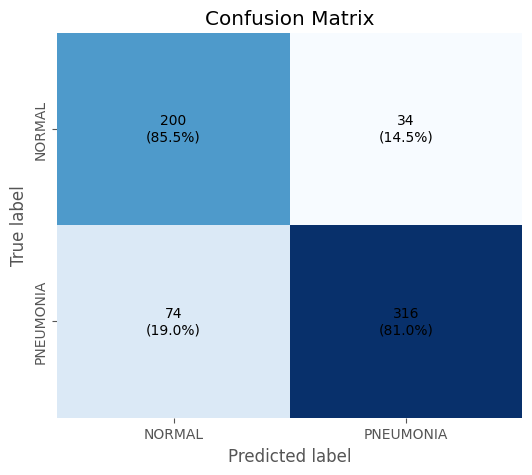

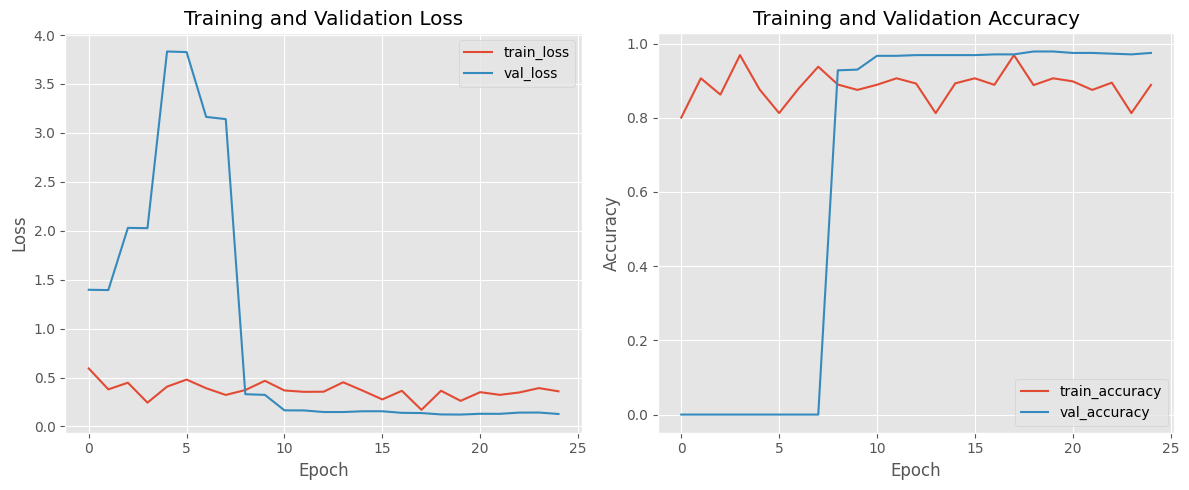


AUROC Score: 0.9120


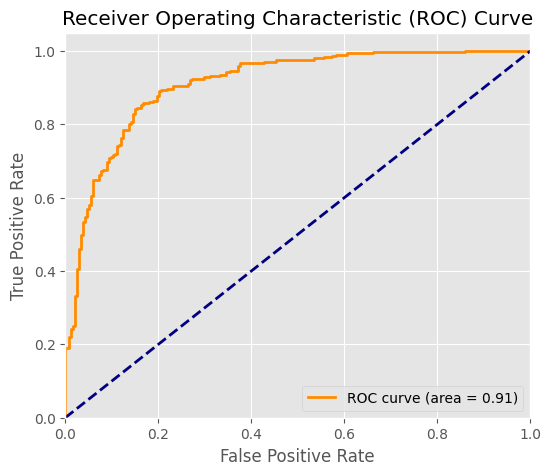

In [ ]:
# Evaluate model
print("\nEvaluating model...")
test_results = model.evaluate(testGen, batch_size=BATCH_SIZE)
print("Test Accuracy: {:.2f}%".format(test_results[1] * 100))
print("Test Loss: {:.4f}".format(test_results[0]))

# Predictions and classification report
predIdxs = model.predict(testGen)
predTest = np.argmax(predIdxs, axis=1)

print("\nClassification Report:")
print(classification_report(testGen.classes, predTest, target_names=testGen.class_indices.keys()))

# Confusion matrix
cm = confusion_matrix(testGen.classes, predTest)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
# Calculate Sensitivity and Specificity
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print("\nConfusion Matrix:")
print(cm)
print("Accuracy: {:.4f}".format(acc))
print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

# Plot confusion matrix with class-wise percentages
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=testGen.class_indices.keys(),
                yticklabels=testGen.class_indices.keys(),
                cbar=False)

# Add annotations with counts and class-wise percentages
for i in range(cm.shape[0]):
    row_sum = cm[i, :].sum()
    for j in range(cm.shape[1]):
        percentage = (cm[i, j] / row_sum) * 100 if row_sum > 0 else 0
        ax.text(j + 0.5, i + 0.5, f"{cm[i, j]}\n({percentage:.1f}%)",
                ha='center', va='center', color='black')

plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate and plot AUROC
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class (PNEUMONIA)
pred_probs = predIdxs[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(testGen.classes, pred_probs)
roc_auc = auc(fpr, tpr)

print(f"\nAUROC Score: {roc_auc:.4f}")

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### **Evaluate Best-Saved Model**


Evaluating the best model...
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8409 - loss: 0.3927
Best Model Test Accuracy: 82.69%
Best Model Test Loss: 0.3950
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step

Classification Report for Best Model:
              precision    recall  f1-score   support

      NORMAL     0.7299    0.8547    0.7874       234
   PNEUMONIA     0.9029    0.8103    0.8541       390

    accuracy                         0.8269       624
   macro avg     0.8164    0.8325    0.8207       624
weighted avg     0.8380    0.8269    0.8291       624


Confusion Matrix for Best Model:
[[200  34]
 [ 74 316]]
Best Model Accuracy: 0.8269
Best Model Sensitivity: 0.8103
Best Model Specificity: 0.8547


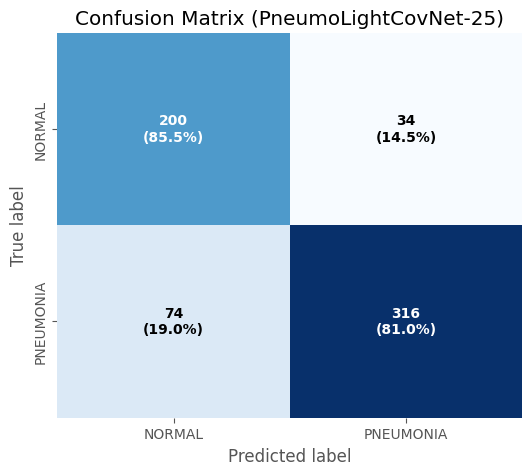


Best Model AUROC Score: 0.9120


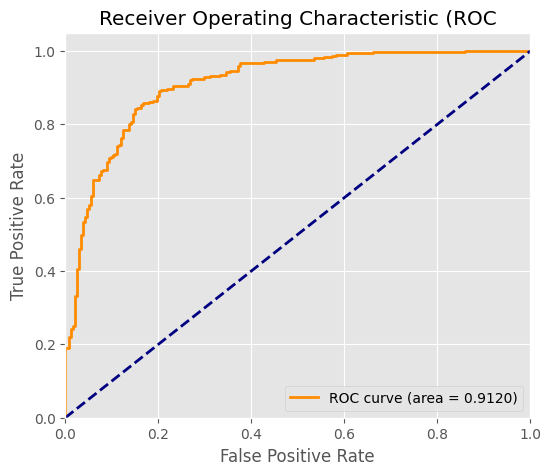

In [ ]:
from tensorflow.keras.models import load_model
import glob
import re
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, f1_score

# Find the best model based on the lowest validation loss
list_of_files = glob.glob('/content/drive/MyDrive/chest_xray/pneumolightcovnet25_weights-*.keras')

def extract_loss_from_filename(filename):
    match = re.search(r'-(\d+\.\d+)\.keras$', filename)
    if match:
        return float(match.group(1))
    return float('inf') # Return infinity for files that don't match the pattern

best_file = min(list_of_files, key=extract_loss_from_filename)

# Load the best model
best_model = load_model(best_file)

# Evaluate the best model
print("\nEvaluating the best model...")
best_test_results = best_model.evaluate(testGen, batch_size=BATCH_SIZE)
print("Best Model Test Accuracy: {:.2f}%".format(best_test_results[1] * 100))
print("Best Model Test Loss: {:.4f}".format(best_test_results[0]))

# Predictions and classification report for the best model
predIdxs_best = best_model.predict(testGen)
predTest_best = np.argmax(predIdxs_best, axis=1)

print("\nClassification Report for Best Model:")
print(classification_report(testGen.classes, predTest_best, target_names=testGen.class_indices.keys(), digits=4))

# Confusion matrix for the best model
cm_best = confusion_matrix(testGen.classes, predTest_best)
total_best = sum(sum(cm_best))
acc_best = (cm_best[0, 0] + cm_best[1, 1]) / total_best
sensitivity_best = cm_best[1, 1] / (cm_best[1, 0] + cm_best[1, 1])
specificity_best = cm_best[0, 0] / (cm_best[0, 0] + cm_best[0, 1])

print("\nConfusion Matrix for Best Model:")
print(cm_best)
print("Best Model Accuracy: {:.4f}".format(acc_best))
print("Best Model Sensitivity: {:.4f}".format(sensitivity_best))
print("Best Model Specificity: {:.4f}".format(specificity_best))

# Plot confusion matrix with class-wise percentages for the best model
plt.figure(figsize=(6, 5))
ax_best = sns.heatmap(cm_best, annot=False, fmt='d', cmap='Blues',
                  xticklabels=testGen.class_indices.keys(),
                  yticklabels=testGen.class_indices.keys(),
                  cbar=False)

# Add annotations with counts and class-wise percentages
for i in range(cm_best.shape[0]):
    row_sum = cm_best[i, :].sum()
    for j in range(cm_best.shape[1]):
        percentage = (cm_best[i, j] / row_sum) * 100 if row_sum > 0 else 0
        text_color = 'black'
        font_weight = 'bold'
        if i == j:  # Diagonal elements (True Positives and True Negatives)
             text_color = 'white'

        ax_best.text(j + 0.5, i + 0.5, f"{cm_best[i, j]}\n({percentage:.1f}%)",
                  ha='center', va='center', color=text_color, weight=font_weight)


plt.title('Confusion Matrix (PneumoLightCovNet-25)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Calculate and plot AUROC for the best model
pred_probs_best = predIdxs_best[:, 1]
fpr_best, tpr_best, thresholds_best = roc_curve(testGen.classes, pred_probs_best)
roc_auc_best = auc(fpr_best, tpr_best)

print(f"\nBest Model AUROC Score: {roc_auc_best:.4f}")

plt.figure(figsize=(6, 5))
plt.plot(fpr_best, tpr_best, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc_best)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC')
plt.legend(loc="lower right")
plt.show()

## **Deployment Metrics (Optional)**

In [ ]:
import os
import time
import numpy as np
import psutil
import threading
import gc
from tensorflow.keras.models import load_model
import glob
import re


# 1. Identify and Load PneumoLightConvNet-25 Model
# Find the checkpoint file with lowest validation loss
checkpoint_files = glob.glob("/content/drive/MyDrive/chest_xray/pneumolightcovnet25_weights-*.keras")
best_file = None
best_loss = float('inf')
for file in checkpoint_files:
    m = re.search(r'pneumolightcovnet25_weights-\d+-([0-9]+\.[0-9]+)\.keras', file)
    if m:
        loss = float(m.group(1))
        if loss < best_loss:
            best_loss = loss
            best_file = file

if not best_file:
    raise FileNotFoundError("No PneumoLightConvNet-25 checkpoint found.")
model = load_model(best_file)
model_size_mb = os.path.getsize(best_file) / (1024 ** 2)
print(f"Loaded PneumoLightConvNet-25 from: {best_file}")
print(f"Model size: {model_size_mb:.2f} MB")


# 2. System Hardware Specifications (unchanged)
cpu_freq = psutil.cpu_freq().current
cpu_cores_phys = psutil.cpu_count(logical=False)
cpu_cores_log = psutil.cpu_count(logical=True)
total_ram_gb = psutil.virtual_memory().total / (1024 ** 3)
print(f"CPU: {cpu_freq:.0f} MHz, {cpu_cores_phys}p/{cpu_cores_log}l cores")
print(f"Total RAM: {total_ram_gb:.2f} GB")


# 3. Memory Utilization Analysis (unchanged)
process = psutil.Process(os.getpid())
ram_after_load_mb = process.memory_info().rss / (1024 ** 2)
print(f"RAM after load (RSS): {ram_after_load_mb:.1f} MB")

# Prepare test image
testGen.reset()
test_images, _ = next(testGen)
sample_image = test_images[0:1]

# Stabilize memory
_ = model.predict(sample_image, verbose=0)
gc.collect()

# Capture memory during inference
ram_before = process.memory_info().rss
_ = model.predict(sample_image, verbose=0)
ram_after = process.memory_info().rss

ram_peak_mb = max(ram_before, ram_after) / (1024 ** 2)
ram_used_mb = ram_peak_mb - ram_after_load_mb
print(f"Peak RAM during inference: {ram_peak_mb:.1f} MB")
print(f"RAM used by inference: {ram_used_mb:.1f} MB")


# 4. Inference Time Performance (unchanged)
testGen.reset()
test_images, _ = next(testGen)
num_images = 50
test_samples = test_images[:num_images]

# Warm-up
_ = model.predict(test_samples[0:1], verbose=0)

# Measure latency
times_ms = []
start = time.perf_counter()
_ = model.predict(test_samples, verbose=0)
end = time.perf_counter()
time_per_image_ms = (end - start) * 1000 / num_images
times_ms.append(time_per_image_ms)

mean_inf_ms = np.mean(times_ms)
std_inf_ms = np.std(times_ms) if len(times_ms) > 1 else 0
print(f"Inference time ({num_images} images): {mean_inf_ms:.2f} ± {std_inf_ms:.2f} ms (per image)")


# 5. CPU Utilization and Power Estimation (unchanged)
cpu_samples = []
stop_sampling = False

def monitor_cpu(interval=0.05):
    while not stop_sampling:
        cpu_samples.append(psutil.cpu_percent(interval=interval))

monitor_thread = threading.Thread(target=monitor_cpu)
monitor_thread.daemon = True
monitor_thread.start()

test_img = test_samples[0:1]
start_wall = time.perf_counter()
_ = model.predict(test_img, verbose=0)
end_wall = time.perf_counter()

stop_sampling = True
monitor_thread.join(timeout=1.0)

avg_cpu = np.mean(cpu_samples) if cpu_samples else 0
est_power_w = (avg_cpu / 100) * 5  # Raspberry Pi power model
print(f"CPU utilization: {avg_cpu:.1f}%")
print(f"Estimated power: {est_power_w:.2f} W (Pi equivalent)")


# 6. Results Summary for PneumoLightConvNet-25
print("\n" + "="*50)
print(f"{' PNEUMOLIGHTCONVNET-25 DEPLOYMENT METRICS ':.^50}")
print("="*50)
print(f"Model size: {model_size_mb:.2f} MB")
print(f"Inference time ({num_images} images): {mean_inf_ms:.2f} ± {std_inf_ms:.2f} ms")
print(f"Estimated power: {est_power_w:.2f} W")
print("Clinical viability: " +
      ("Yes" if mean_inf_ms <= 1000 and model_size_mb <= 50 else "No"))
print("="*50)

Loaded PneumoLightConvNet-25 from: /content/drive/MyDrive/chest_xray/pneumolightcovnet25_weights-020-0.1216.keras
Model size: 33.01 MB
CPU: 2200 MHz, 1p/2l cores
Total RAM: 12.67 GB
RAM after load (RSS): 885.6 MB
Peak RAM during inference: 950.5 MB
RAM used by inference: 64.8 MB
Inference time (50 images): 103.39 ± 0.00 ms (per image)
CPU utilization: 38.1%
Estimated power: 1.90 W (Pi equivalent)

.... PNEUMOLIGHTCONVNET-25 DEPLOYMENT METRICS ....
Model size: 33.01 MB
Inference time (50 images): 103.39 ± 0.00 ms
Estimated power: 1.90 W
Clinical viability: Yes
